# Prediction of the second round presidential elections of 2017.

*Gaspard Michel, Raphaël Gervillié* 

This challenge was done as part of the [Datacamp](https://github.com/x-datascience-datacamp) 2021-2022 course.

![IPP.jpg](https://www.ip-paris.fr/themes/project/img/home/logo_og.jpg)



## Introduction

France, like many countries, operates by the system of universal suffrage. During each vote, 
the results are final when all the votes have finished being counted. But some estimation can be made on the final results during the day. This challenge proposes to explore models allowing to predict the results using only half of the votes. This type of challenge is part of all the economic issues that are seeing a revival with the arrival of machine learning methods. With the increase of available data in open access, it is possible to better model complex economic problems. This challenge therefore aims on the one hand to improve the estimate of the election results and on the other hand to propose an original model allowing to capture the multiple dimensions of this problem.


## Data description

The particularity of the approach comes from the multiple sources of data that are provide for this challenge. We  have the **economic data** at the regional level and at the commune level. These data make it possible to capture the economic situation of a municipality. For example, we have information on the number of businesses, the average tax revenue or the size of the population. All of these factors provide information on voting intentions. The second source of data corresponds to data from **previous elections**. As we are planning the second round, we can use the results of the first round of the presidential elections. Finally, one of the particularity of voting in France comes from its very marked spatial character, this is why we have integrated **spatial data**. To integrate spatial information in our modeling we also provide a graph. Having as node the communes and as link the distance which separates them. We considered that a distance greater than 10km had less influence. Thus there is a link between two municipalities if their distance is less than 10 km. We will see later in this notebook that the spatial dimension plays an important role in modelling.


In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
from IPython import display
import networkx as nx
import pandas as pd



### Economic data

The economic data comes from [INSEE](https://www.data.gouv.fr/en/datasets/data-insee-sur-les-communes/). They are of two types of scale, by communes and by region. They are used to model the economic and structural situation of municipalities.


#### Communes level.



In [43]:
node_features = pd.read_csv('data/node_features.csv',index_col="Unnamed: 0",low_memory=False)

In [44]:
node_features

,reg_id,dep_id,Inscrits_t2,Votants_t2,y,Votants_t1,Abstentions_t1,Inscrits_t1,Resultat_t1,Population,Evolution Population,Nb Majeurs,Nb Etudiants,Nb propriétaire,Nb Logement Secondaire et Occasionnel,Nb Occupants Résidence Principale,Score Urbanité,Indice Evasion Client,Capacité Fiscale,CODGEO
0,82.0,01,887,688,0.587849,723.0,164.0,887.0,"{'Marine LE PEN': 184, 'Emmanuel MACRON': 155,...",816.0,-15.0,639.0,58.0,284.0,127.0,814.0,0.0,0.00000,118.0,01073
1,82.0,01,4358,3190,0.647779,3296.0,1061.0,4357.0,"{'Marine LE PEN': 788, 'Emmanuel MACRON': 741,...",6456.0,624.0,4643.0,526.0,1045.0,49.0,6323.0,87.5,0.00000,190.0,01262
2,82.0,01,220,179,0.589744,187.0,33.0,220.0,"{'Marine LE PEN': 52, 'François FILLON': 39, '...",300.0,17.0,224.0,20.0,85.0,8.0,300.0,0.0,0.00000,112.0,01425
3,22.0,02,282,233,0.446602,229.0,53.0,282.0,"{'Marine LE PEN': 84, 'Jean-Luc MÉLENCHON': 40...",381.0,6.0,301.0,28.0,132.0,23.0,376.0,0.0,0.00000,71.0,02042
4,22.0,02,325,262,0.323404,267.0,58.0,325.0,"{'Marine LE PEN': 129, 'François FILLON': 46, ...",424.0,7.0,326.0,29.0,129.0,17.0,424.0,0.0,0.00000,71.0,02140
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35167,43.0,90,1116,811,0.446176,848.0,269.0,1117.0,"{'Marine LE PEN': 296, 'Emmanuel MACRON': 165,...",1419.0,124.0,1043.0,92.0,253.0,2.0,1381.0,25.0,0.00000,90.0,90017
35168,11.0,92,47455,35531,0.843831,37740.0,9714.0,47454.0,"{'Emmanuel MACRON': 11238, 'Jean-Luc MÉLENCHON...",76690.0,5126.0,57940.0,5972.0,13070.0,526.0,75062.0,100.0,1614.96071,-2431.0,92025
35169,11.0,95,2696,2033,0.583893,2163.0,533.0,2696.0,"{'Marine LE PEN': 582, 'Emmanuel MACRON': 480,...",3248.0,76.0,2399.0,288.0,984.0,57.0,3250.0,37.5,248.45549,230.0,95149
35170,11.0,95,1263,1017,0.763476,1096.0,173.0,1269.0,"{'Emmanuel MACRON': 351, 'François FILLON': 28...",1433.0,49.0,1047.0,152.0,417.0,16.0,1432.0,100.0,0.00000,204.0,95450


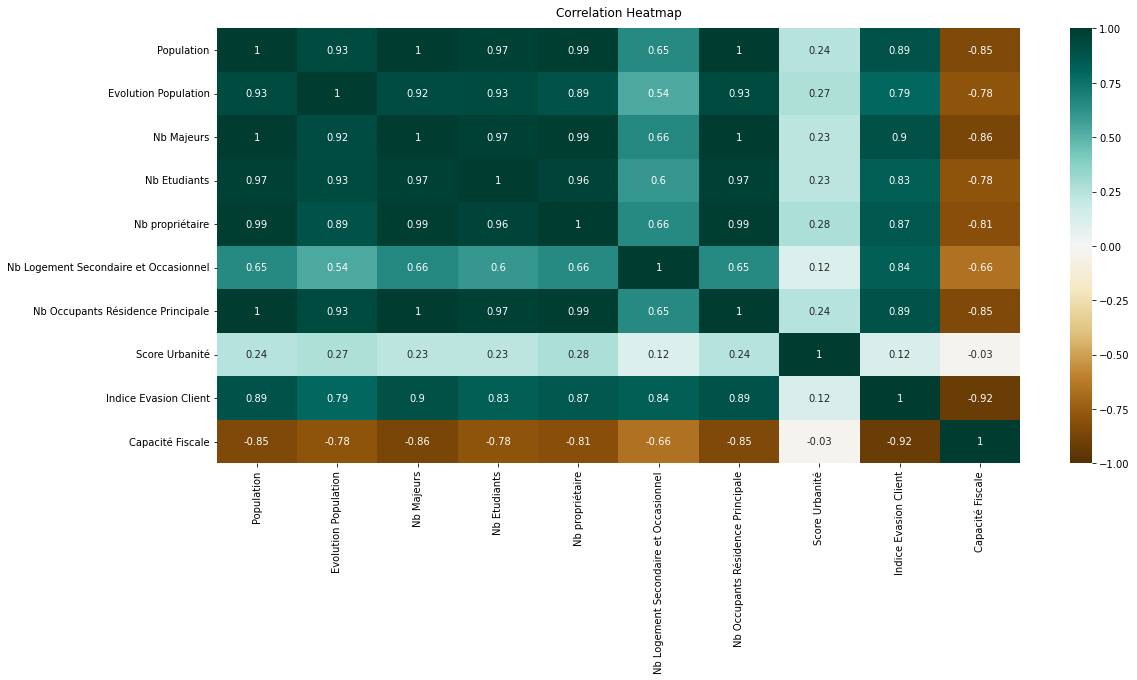

In [3]:
features_elections = ['Inscrits_t2', 'Votants_t2',"Votants_t1",'Abstentions_t1', 'Inscrits_t1', 'Resultat_t1']
features_eco = ['Population','Evolution Population', 'Nb Majeurs', 'Nb Etudiants', 'Nb propriétaire',
'Nb Logement Secondaire et Occasionnel','Nb Occupants Résidence Principale', 'Score Urbanité',
'Indice Evasion Client', 'Capacité Fiscale']
plt.figure(figsize=(18, 8))
heatmap = sns.heatmap(node_features[features_eco].corr(), vmin=-1, vmax=1, annot=True,cmap='BrBG')
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':12}, pad=12);

#### Departement level.

In [4]:
region_features=pd.read_csv("data/region.csv")

In [5]:
features_region = ['Nb de Commerce', 'Nb Industries des biens intermédiaires',
       'Valeur ajoutée régionale', 'Nb de Services aux particuliers',
       'Nb institution de Education, santé, action sociale, administration',
       'PIB Régionnal', 'Moyenne Revenus Fiscaux Régionaux']

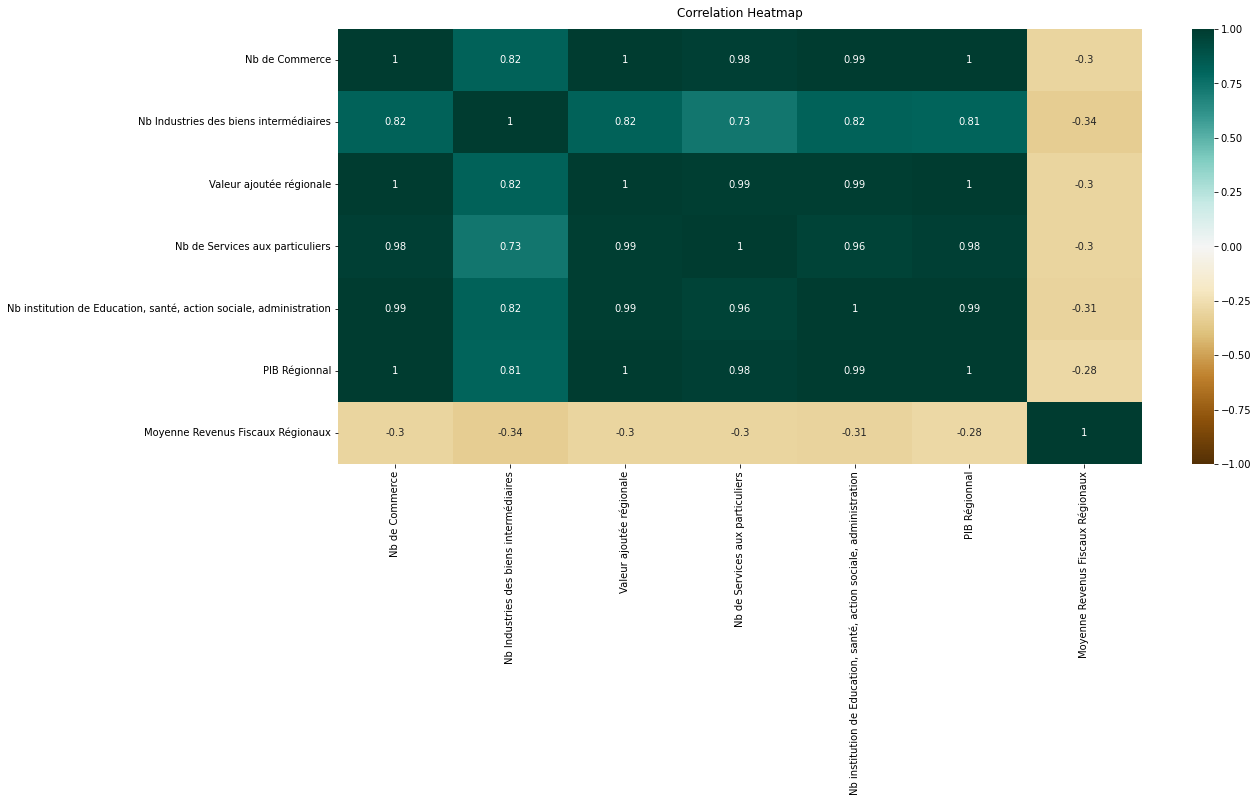

In [6]:
plt.figure(figsize=(18, 8))
heatmap = sns.heatmap(region_features[features_region].corr(), vmin=-1, vmax=1, annot=True,cmap='BrBG')
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':12}, pad=12);

### Elections

Data on presidential elections or more generally on votes in France are available on the [data.gouv](https://www.data.gouv.fr/fr/pages/donnees-des-elections/) platform.
As we are interested in the second round. We have provided data from the first round of the presidential elections which is a very good proxy for the second round. We have not added other votes (legislative, European, etc.), because we considered that the information was already contained in the results of the first round. The following figures present the results of the first and second round of the 2017 presidential election. Note that the results are slightly different from the official results. The reason comes from missing data of certain municipalities, in particular the DROM  (Départements ou Régions français d’Outre-Mer) and the COM (Collectivités d'Outre-Mer). 

In [7]:
node_features[features_elections].head()

,Inscrits_t2,Votants_t2,Votants_t1,Abstentions_t1,Inscrits_t1,Resultat_t1
node_id,,,,,,
0,598,498,506.0,92.0,598.0,0.0
1,209,177,184.0,25.0,209.0,0.0
2,8586,6274,6624.0,1962.0,8586.0,0.0
3,1172,913,957.0,215.0,1172.0,0.0
4,99,76,79.0,20.0,99.0,8.0


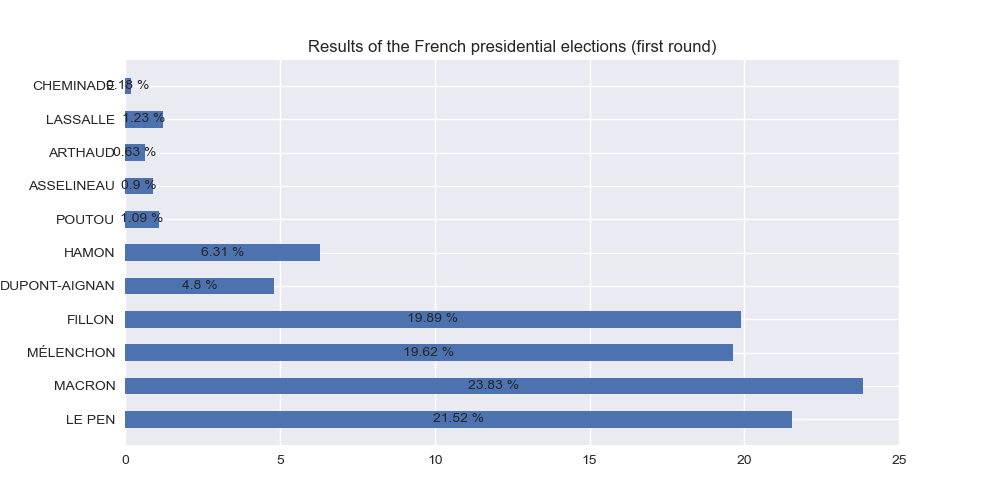

In [8]:
display.Image("data/images/results_t1.png")

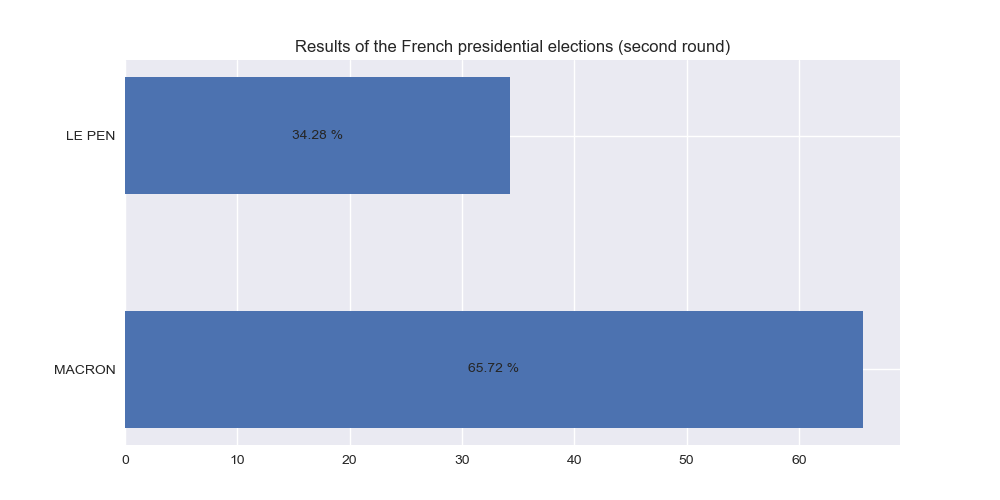

In [9]:
display.Image("data/images/results_t2.png")

## Spatial data

The spatial data was taken from [Gregoiredavid](https://github.com/gregoiredavid/france-geojson)'s GitHub which provides a large number of geographical data for France. The two figures below are maps of France. We have displayed the winner by municipality in France, during the first and second rounds. We see, for example, that it was Marine LE PEN who won the most municipalities in the first round, then Emmanuel MACRON in the second. There are also clusters where all the municipalities vote in the same way, for example in the North there is a greater tendency to vote for LE PEN and in the south-west for Macron. Integrating this spatial information is one of the challenges of this data-challenge.


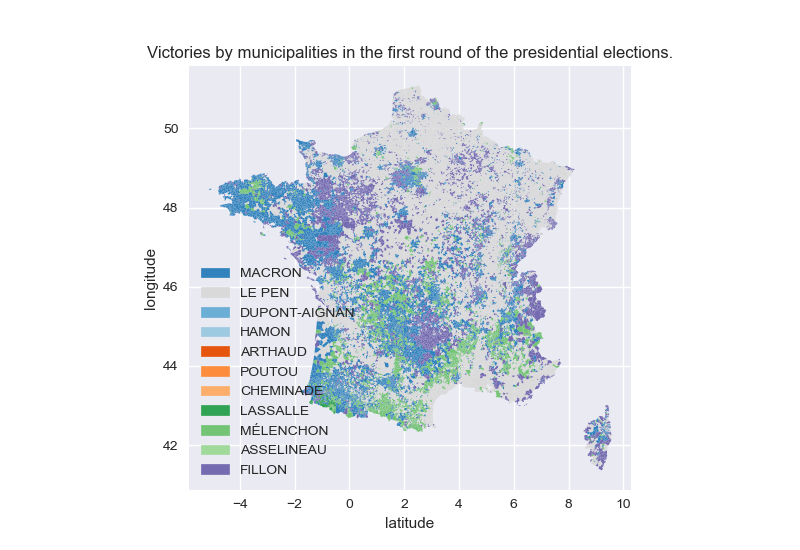

In [10]:
display.Image("data/images/m1.png")

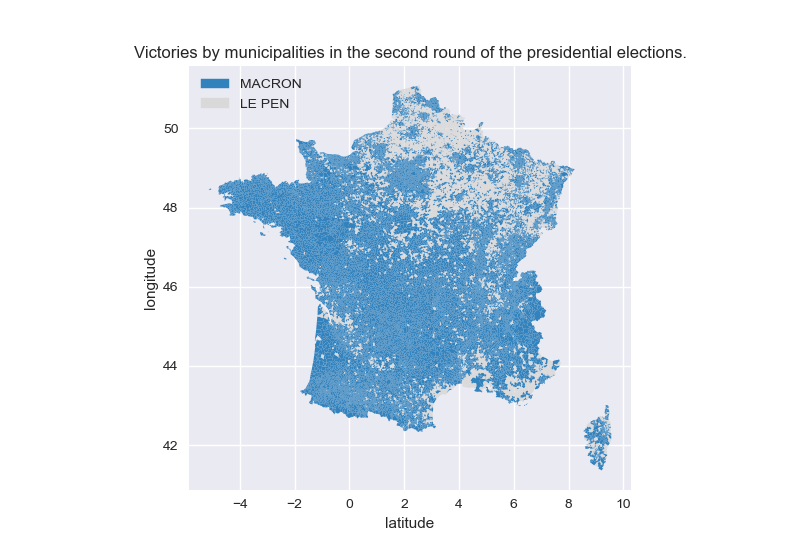

In [11]:
display.Image("data/images/m2.png")

Spatial data on the geographical position of the municipalities are not directly provided during this challenge in order to avoid cheating. We preferred to provide them in the form of a weighted graph. This graph takes the municipalities as nodes and has the distance between municipalities as links. If this distance exceeds 10 km there is no link, if it is less than 10 km then we give a value ranging from 0 to 1. 1 being the closest and 0 the farthest. On the graph below we can see the distribution of nodes. We see that the municipalities have an average of around 50 neighbours. But some will have much more, and others much less.


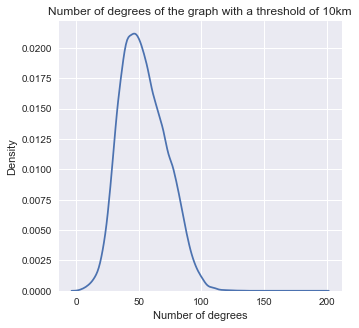

In [12]:
G=nx.read_weighted_edgelist("data/edgelist_dist10000_id")

plt.style.use('seaborn')
g=sns.displot(G.degree,kind="kde")
plt.xlabel("Number of degrees")
plt.ylabel("Density")
plt.title('Number of degrees of the graph with a threshold of 10km')
g._legend.remove()
plt.subplots_adjust(bottom=0.15,top=0.9)

## Modelization